### **Ascending input vs. descending input vs. combined ascending and descending input.**

In [2]:
import os
os.chdir('..')
from glob import glob
from notebooks import config
import numpy as np
import pandas as pd
import seaborn as sns
from utils.imgShow import imgShow, imsShow
import matplotlib.pyplot as plt
from utils.metrics_plot import csv_merge, smooth
from utils.metric import acc_matrix, acc_miou
from utils.raster_vec import vec2mask
from utils.geotif_io import readTiff
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap


#### 1. Check metrics during model training

In [4]:
##### selection for test scene mapping: 
####################################################################
## 1. Model name and the selected metric
# id_model =  '10'
# model_name = ['model_single_test_'+id_model, 'model_scales_test_'+id_model, 'model_gscales_test_'+id_model]
model_name = ['gscales/traset/as/model_1', 'gscales/traset/des/model_1', 'gscales/traset/as_des/model_1']

# metric_name = 'val_miou'
path_metrics_as = config.root_proj + '/model/trained_model/' + model_name[0] + '_metrics.csv'
path_metrics_des = config.root_proj + '/model/trained_model/' + model_name[1] + '_metrics.csv'
path_metrics_as_des = config.root_proj + '/model/trained_model/' + model_name[2] + '_metrics.csv'

## 2. Read metric file (each file corresponding to one model and contains all metrics)
metrics_as = pd.read_csv(path_metrics_as)
metrics_des = pd.read_csv(path_metrics_des)
metrics_as_des = pd.read_csv(path_metrics_as_des)
metrics_as.tail(2)
# metrics_des.tail(2)



,tra_loss,tra_miou,val_loss,val_miou
298,0.351354,0.850266,0.201071,0.855900
299,0.350286,0.855514,0.201062,0.855929


### 2. Accuracy assessment for each test scene and each pretrained model(different input).

In [5]:
# for id in range(10):
#     id_model = 'model_' + str(id+1)
id_model = 'model_1'
oa_, miou_, oa_as_, miou_as_, oa_des_, miou_des_ = [], [], [], [], [], []

# for idx in range(7):
for idx in config.val_ids: 
    scene_id = 'scene' + str(idx+1).zfill(2)
    path_valsite_wat_as =config.root_proj+'/data/dset/valsite_wat_infer/gscales/as/'+id_model+'/'+scene_id+'_s1as_water.tif'
    path_valsite_wat_des=config.root_proj+'/data/dset/valsite_wat_infer/gscales/des/'+id_model+'/'+scene_id+'_s1des_water.tif'
    path_valsite_wat = config.root_proj+'/data/dset/valsite_wat_infer/gscales/as_des/'+id_model+'/'+scene_id+'_s1_water.tif'
    path_valsite_s1as = config.root_proj+'/data/dset/s1_ascend/'+scene_id+'_s1as.tif'
    # path_valsite_des = config.root_proj+'/data/dset/s1_descend/'+scene_id+'_s1des.tif'
    path_valsite_truth = config.root_proj+'/data/dset/s1_truth/'+scene_id+'_wat_truth.tif'
    ## --- read in data
    s1_as, s1_as_info = readTiff(path_valsite_s1as)
    truth, truth_info = readTiff(path_valsite_truth)
    wat, wat_info = readTiff(path_valsite_wat)
    wat_as, wat_as_info = readTiff(path_valsite_wat_as)
    wat_des, wat_des_info = readTiff(path_valsite_wat_des)

    ### ---- combined ascending and descending input
    oa_i, prod_i, user_i, confus_mat_i = acc_matrix(cla_map=wat, truth_map=truth, id_label=1)
    miou_i = acc_miou(cla_map=wat, truth_map=truth, labels=[1])
    oa_.append(float(format(oa_i, '.4f'))), miou_.append(float(format(miou_i, '.4f')))
    ### ---- ascending input only
    oa_as_i, _, _, _ = acc_matrix(cla_map=wat_as, truth_map=truth, id_label=1)
    miou_as_i = acc_miou(cla_map=wat_as, truth_map=truth, labels=[1])
    oa_as_.append(float(format(oa_as_i, '.4f'))), miou_as_.append(float(format(miou_as_i, '.4f')))
    ### ---- descending input only
    oa_des_i, _, _, _ = acc_matrix(cla_map=wat_des, truth_map=truth, id_label=1)
    miou_des_i = acc_miou(cla_map=wat_des, truth_map=truth, labels=[1])
    oa_des_.append(float(format(oa_des_i, '.4f'))), miou_des_.append(float(format(miou_des_i, '.4f')))

### ---- save .csv file
### the .csv saves accuracy metrics derived by models trained with ascend data, 
### descend data and combined ascend and descend data.
path_metrics = config.root_proj+ '/data/dset/valsite_wat_infer/gscales/acc_eval/acc_' + id_model + '.csv'
metrics = {'oa': oa_, 'oa_as': oa_as_, 'oa_des': oa_des_, \
                        'miou':miou_, 'miou_as':miou_as_, 'miou_des':miou_des_, 'model_id': id_model}
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(path_metrics, index=False, sep=',')
print(metrics_df)




       oa   oa_as  oa_des    miou  miou_as  miou_des model_id
0  0.9956  0.9787  0.9945  0.9642   0.8281    0.9561  model_1
1  0.9395  0.7695  0.8904  0.7900   0.1766    0.6436  model_1
2  0.9537  0.9683  0.8533  0.9176   0.9434    0.7404  model_1
3  0.9412  0.8867  0.9187  0.6865   0.3905    0.5752  model_1
4  0.9857  0.9879  0.9856  0.5268   0.5701    0.5063  model_1
5  0.9743  0.8846  0.8853  0.8925   0.4880    0.6554  model_1
6  0.8937  0.9362  0.8258  0.6557   0.7667    0.4729  model_1
7  0.9732  0.9786  0.9824  0.1560   0.2955    0.4984  model_1
8  0.9512  0.9801  0.9544  0.0521   0.1209    0.0548  model_1
9  0.8250  0.8158  0.7419  0.6382   0.6138    0.4757  model_1
       oa   oa_as  oa_des    miou  miou_as  miou_des model_id
0  0.9899  0.9786  0.9918  0.9210   0.8349    0.9362  model_2
1  0.8920  0.8817  0.9072  0.6522   0.5885    0.6921  model_2
2  0.9559  0.7621  0.9269  0.9229   0.5772    0.8721  model_2
3  0.9025  0.8788  0.9351  0.4828   0.3548    0.6531  model_2
4  0.975

#### Save the accuracy metrics to .csv file

### 3. load and concat metrics obtained by different iteration model.

In [15]:
metrics_paths = glob('/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/valsite_wat_infer/gscales/acc_eval/*')
metrics_models = csv_merge(metrics_paths, i_row='scene_id')
metrics_models



,oa,oa_as,oa_des,miou,miou_as,miou_des,model_id,scene_id
0,0.9954,0.9681,0.9920,0.9628,0.7793,0.9372,model_7,1
1,0.9202,0.8874,0.9038,0.7251,0.6208,0.6656,model_7,2
2,0.9488,0.6497,0.8930,0.9086,0.3877,0.8093,model_7,3
3,0.9369,0.9259,0.9340,0.6613,0.6041,0.6460,model_7,4
4,0.9894,0.9844,0.9880,0.6404,0.5407,0.5614,model_7,5
...,...,...,...,...,...,...,...,...
95,0.9830,0.9318,0.8564,0.9270,0.7263,0.6017,model_8,6
96,0.8800,0.9136,0.8994,0.6269,0.7332,0.6501,model_8,7
97,0.9813,0.9443,0.9842,0.4088,0.0503,0.4252,model_8,8
98,0.9486,0.9096,0.9902,0.0721,0.0259,0.3066,model_8,9


### 4. Comparison among orbital data ( box plot with confidence interval)


In [17]:
###  append the mean values (among the test sites)
metrics_mean = metrics_models.groupby('scene_id').mean()
metrics_mean['scene_id'] = 'Average'
metrics_models_ = pd.concat([metrics_models, metrics_mean])
metrics_models_


,oa,oa_as,oa_des,miou,miou_as,miou_des,model_id,scene_id
0,0.99540,0.96810,0.99200,0.96280,0.77930,0.93720,model_7,1
1,0.92020,0.88740,0.90380,0.72510,0.62080,0.66560,model_7,2
2,0.94880,0.64970,0.89300,0.90860,0.38770,0.80930,model_7,3
3,0.93690,0.92590,0.93400,0.66130,0.60410,0.64600,model_7,4
4,0.98940,0.98440,0.98800,0.64040,0.54070,0.56140,model_7,5
...,...,...,...,...,...,...,...,...
6,0.97682,0.91186,0.89358,0.90258,0.62121,0.67552,NaN,Average
7,0.87765,0.90566,0.83454,0.61377,0.71431,0.53701,NaN,Average
8,0.96922,0.96262,0.97524,0.23569,0.11253,0.44381,NaN,Average
9,0.95221,0.94161,0.94732,0.10252,0.04437,0.09316,NaN,Average


In [20]:
### extract specific metric (oa) derived by models.
metrics_lenth = len(metrics_models_)
oa = list(metrics_models_['oa']) + list(metrics_models_['oa_as']) + list(metrics_models_['oa_des'])
models_name = ['Combined ascending and descending images' for i in range(metrics_lenth)] \
            + ['Ascending image only' for i in range(metrics_lenth)] \
            + ['Descending image only' for i in range(metrics_lenth)]
scene_id = list(metrics_models_['scene_id'])*3
metrics_oa = {'oa': oa, 'Input image': models_name, 'scene_id': scene_id}
metrics_oa = pd.DataFrame(metrics_oa)
metrics_oa



,oa,Input image,scene_id
0,0.99540,Combined ascending and descending images,1
1,0.92020,Combined ascending and descending images,2
2,0.94880,Combined ascending and descending images,3
3,0.93690,Combined ascending and descending images,4
4,0.98940,Combined ascending and descending images,5
...,...,...,...
325,0.89358,Descending image only,Average
326,0.83454,Descending image only,Average
327,0.97524,Descending image only,Average
328,0.94732,Descending image only,Average


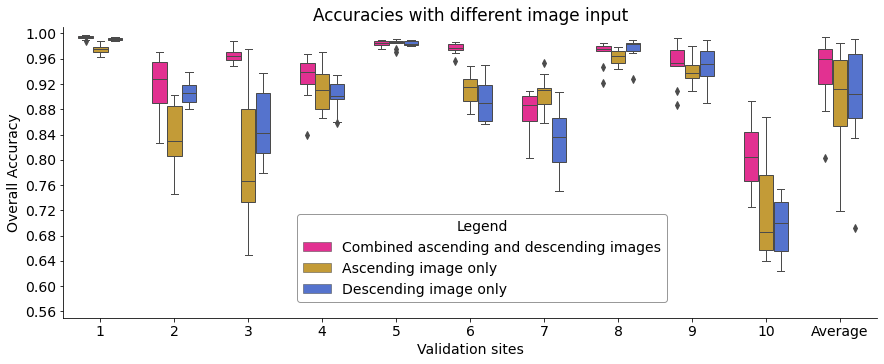

In [27]:
plt.rcParams.update({'font.size': 14})
# colors = ['red', 'blue', 'green']
colors = ['DeepPink', 'Goldenrod', 'RoyalBlue']
g = sns.catplot(data=metrics_oa, x= "scene_id", y = "oa", hue='Input image', kind="box", legend = False,
                width=0.6, palette=colors, linewidth=1, height=5, aspect=2.5, ci=90)
g.set(ylim=(0.55, 1.01))\
  .set(xlabel='Validation sites',ylabel='Overall Accuracy',title='Accuracies with different image input')
ax = plt.gca()
y_major_locator=MultipleLocator(0.04)
ax.yaxis.set_major_locator(y_major_locator)
plt.legend(title='Legend', loc = 'lower right', fontsize='medium', edgecolor='gray',bbox_to_anchor=(0.75, 0.03))
# plt.savefig(config.root_proj + '/figure/orbit_input_compare.png', bbox_inches='tight')



### 5. Show the water maps derived by different image input


In [48]:
id_model='model_1'   ## the model selected
cmap_wat = ListedColormap(["white", "blue"])
cmap_dif = ListedColormap(['red', 'black', 'blue','white'])


In [53]:
s1_as_, s1_des_, truth_, wat_, wat_as_, wat_des_ = [], [], [], [], [], []
for idx in config.val_ids: 
    scene_id = 'scene' + str(idx+1).zfill(2)
    path_valsite_s1as = config.root_proj+'/data/dset/s1_ascend/'+scene_id+'_s1as.tif'
    path_valsite_s1des = config.root_proj+'/data/dset/s1_descend/'+scene_id+'_s1des.tif'
    path_valsite_truth = config.root_proj+'/data/dset/s1_truth/'+scene_id+'_wat_truth.tif'
    path_valsite_wat_as =config.root_proj+'/data/dset/valsite_wat_infer/gscales/as/'+id_model+'/'+scene_id+'_s1as_water.tif'
    path_valsite_wat_des=config.root_proj+'/data/dset/valsite_wat_infer/gscales/des/'+id_model+'/'+scene_id+'_s1des_water.tif'
    path_valsite_wat = config.root_proj+'/data/dset/valsite_wat_infer/gscales/as_des/'+id_model+'/'+scene_id+'_s1_water.tif'
    s1_as, s1_as_info = readTiff(path_valsite_s1as); s1_as_.append(s1_as); 
    s1_des, s1_des_info = readTiff(path_valsite_s1des); s1_des_.append(s1_des);
    truth, truth_info = readTiff(path_valsite_truth); truth_.append(truth); 
    wat_as, wat_as_info = readTiff(path_valsite_wat_as); wat_as_.append(wat_as);
    wat_des, wat_des_info = readTiff(path_valsite_wat_des); wat_des_.append(wat_des)
    wat, wat_info = readTiff(path_valsite_wat); wat_.append(wat);  


#### **Combined image outperform the single-orbit image only**

size: (3225, 3610)


Text(0.5, 1.0, 'Descending image only')

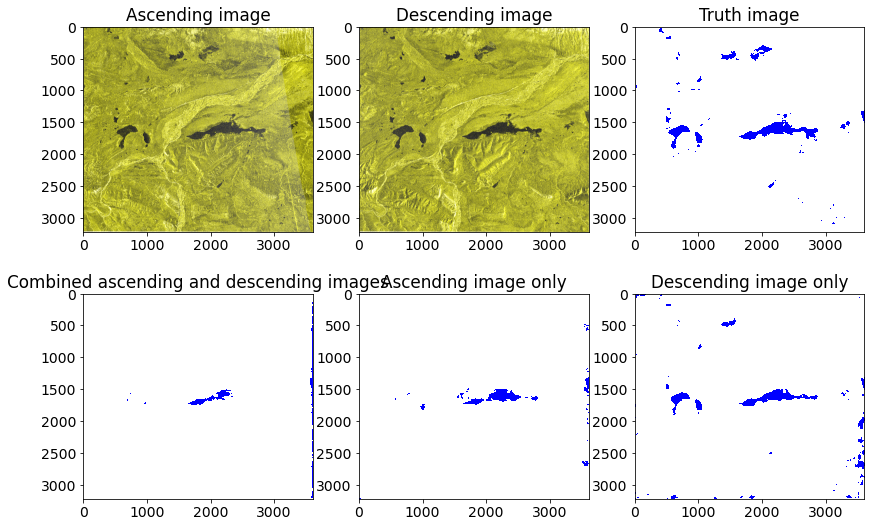

In [57]:
plt.rcParams.update({'font.size': 14})
idx = 7    
print('size:', truth_[idx].shape)
plt.figure(figsize=(14,9))
plt.subplot(2,3,1); imgShow(s1_as_[idx], color_bands=(0,0,1)); plt.title('Ascending image')
plt.subplot(2,3,2); imgShow(s1_des_[idx], color_bands=(0,0,1)); plt.title('Descending image')
plt.subplot(2,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('Truth image')
plt.subplot(2,3,4); plt.imshow(wat_[idx], cmap=cmap_wat); plt.title('Combined ascending and descending images')
plt.subplot(2,3,5); plt.imshow(wat_as_[idx], cmap=cmap_wat); plt.title('Ascending image only')
plt.subplot(2,3,6); plt.imshow(wat_des_[idx], cmap=cmap_wat); plt.title('Descending image only')



Text(0.5, 1.0, 'Descending image only')

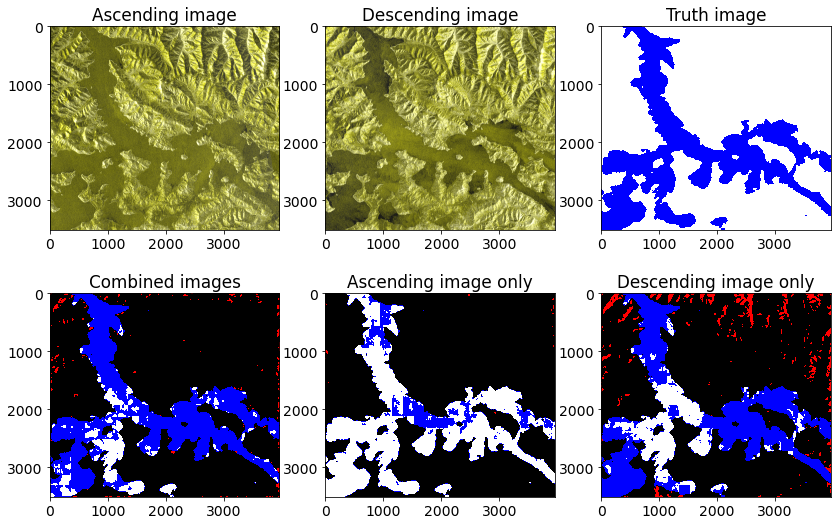

In [44]:
plt.rcParams.update({'font.size': 14})
idx = 1      
dif_as = (truth_[idx]+1)*2 - wat_as_[idx]
dif_des = (truth_[idx]+1)*2 - wat_des_[idx]
dif_as_des = (truth_[idx]+1)*2 - wat_[idx]
plt.figure(figsize=(14, 9))
plt.subplot(2,3,1); imgShow(s1_as_[idx], color_bands=(0,0,1)); plt.title('Ascending image')
plt.subplot(2,3,2); imgShow(s1_des_[idx], color_bands=(0,0,1)); plt.title('Descending image')
plt.subplot(2,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('Truth image')
plt.subplot(2,3,4); plt.imshow(dif_as_des, cmap=cmap_dif); plt.title('Combined images')
plt.subplot(2,3,5); plt.imshow(dif_as, cmap=cmap_dif); plt.title('Ascending image only')
plt.subplot(2,3,6); plt.imshow(dif_des, cmap=cmap_dif); plt.title('Descending image only')
# plt.savefig(config.root_proj + '/figure/orbit_input_compare_scene2.png', bbox_inches='tight')



#### **Single-orbit image only outperform the combined image input.**

size: (3076, 3373)


Text(0.5, 1.0, 'Descending image only')

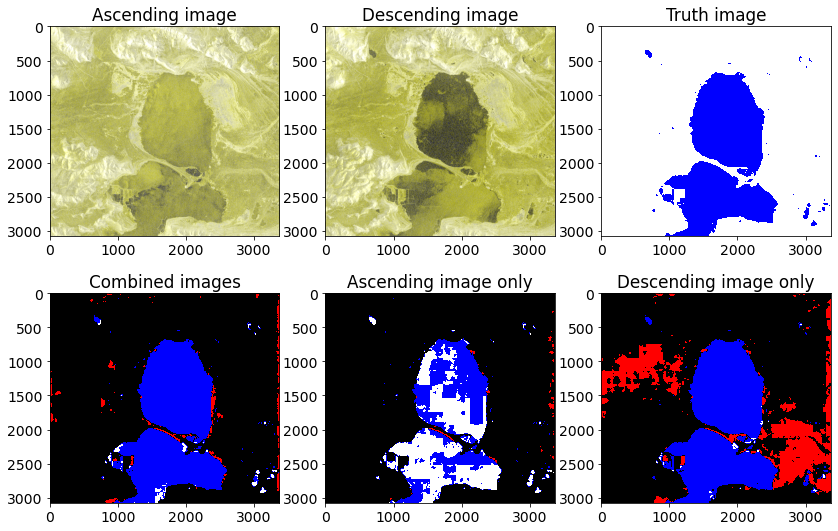

In [51]:
idx = 5
print('size:', truth_[idx].shape)
dif_as = (truth_[idx]+1)*2 - wat_as_[idx]
dif_des = (truth_[idx]+1)*2 - wat_des_[idx]
dif_as_des = (truth_[idx]+1)*2 - wat_[idx]
plt.figure(figsize=(14, 9))
plt.subplot(2,3,1); imgShow(s1_as_[idx], color_bands=(0,0,1)); plt.title('Ascending image')
plt.subplot(2,3,2); imgShow(s1_des_[idx], color_bands=(0,0,1)); plt.title('Descending image')
plt.subplot(2,3,3); plt.imshow(truth_[idx], cmap=cmap_wat); plt.title('Truth image')
plt.subplot(2,3,4); plt.imshow(dif_as_des, cmap=cmap_dif); plt.title('Combined images')
plt.subplot(2,3,5); plt.imshow(dif_as, cmap=cmap_dif); plt.title('Ascending image only')
plt.subplot(2,3,6); plt.imshow(dif_des, cmap=cmap_dif); plt.title('Descending image only')
